Pixel spacing is (0.8, 0.8, 0.8) mm
There are (320, 320, 56) slices in the volume (axial, coronal, sagittal axes respectively)
torch.Size([20, 1, 320, 320])


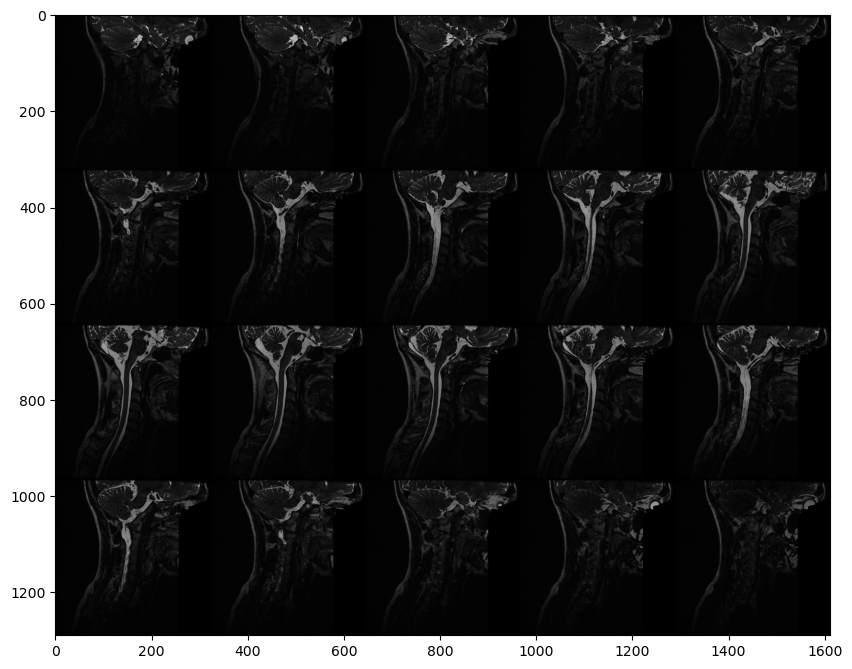

In [29]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import torch
from torchvision.utils import make_grid

file = '/users/rhydian/SpineNet/tutorials/example_scans/sub-perform04/anat/sub-perform04_T2w.nii.gz'

# Load the image and re-orient it to match spinenet input
image = nib.load(file)
ornt = np.array([[0, 1],
                [1, 1],
                [2, -1]])
image = image.as_reoriented(ornt)

# get pixel spacings
sx, sy, sz = image.header.get_zooms()

def show_subset_of_slices(image : np.ndarray, num_slices : int = 10, num_per_row : int = 5) -> plt.figure:
    '''
    Show a subset of the slices in the image.

    Args:
        image (np.ndarray): The image to show
        num_slices (int): The number of slices to show
        num_per_row (int): The number of slices per row
    '''
    image = image.copy()/image.max()

    assert image.ndim == 3, "Image must be 3D, grayscale"
    slices_to_show = [int(i) for i in np.linspace(0, image.shape[-1] -1, num_slices)]
    image = torch.Tensor(image[:,:,slices_to_show]).permute(2,0,1).unsqueeze(1)
    

    print(image.shape)
    grid = make_grid(image, nrow=num_per_row).permute(1,2,0).numpy()
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.imshow(grid, cmap='gray')
    return fig
    
image = image.get_fdata().swapaxes(0,2).copy()

print(f"Pixel spacing is ({sz:.2}, {sy:.2}, {sx:.2}) mm")
print(f"There are {image.shape} slices in the volume (axial, coronal, sagittal axes respectively)")

pixel_spacing = np.array([sx, sy])
slice_thickness = sz


# now show a subset of the slices
fig = show_subset_of_slices(image, 20)
fig.show()


In [30]:
import spinenet
from matplotlib.patches import Polygon
scan = spinenet.io.SpinalScan(image, pixel_spacing, slice_thickness)
spnt = spinenet.SpineNet(device='cuda:0', verbose=True, scan_type='whole')



vert_dicts = spnt.detect_vb(scan.volume, scan.pixel_spacing[0])

print(f"Found {len(vert_dicts)} vertebrae")

Loading Detection Model...
==> Loading model trained for 436 epochs...
Loading Appearance Model...
==> Loading model trained for 188 epochs...
Loading Context Model...
==> Loading model trained for 17 epochs...
Loading Grading Model...
==> Loading model trained for 2 epochs...


/users/rhydian/.conda/envs/pytorch_env/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Found 5 vertebrae


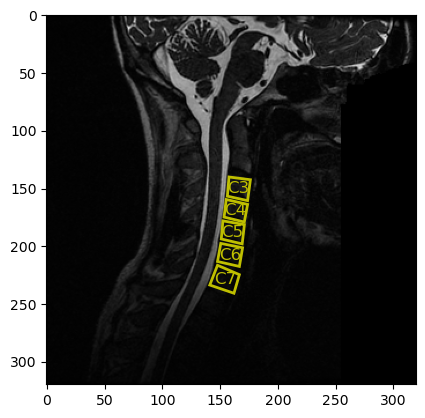

In [31]:

mid_sag = np.median([np.median(v['slice_nos']) for v in vert_dicts]).astype(int)
plt.imshow(scan.volume[:,:,mid_sag], cmap='gray')

for idx, vert_dict in enumerate(vert_dicts):
    avg_poly = np.median(vert_dict['polys'],axis=0)

    plt.gca().add_patch(Polygon(avg_poly, ec='y', fc='none', lw=2))
    plt.text(avg_poly[:,0].mean(), avg_poly[:,1].mean(), 
             vert_dict['predicted_label'], color='y', fontsize=12, ha='center', va='center')

plt.show()
